# Advanced Programming for Data Science
*Code proposition done by:*
```
Farouq El-Abbass
Moritz Häckel
Dominik Trut
Moritz Güttersberger
```

Our project consisted of creating a module for studying the energy production and consumption per country, and as well the produced CO2 for each energy source.

We are going to start by *importing* the libraries we have used

In [2]:
import requests
import pandas as pd
import os
import plotly_express as px
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import statsmodels.api as sm
from pmdarima import auto_arima
style.use("ggplot")

### Our proposition for the class is as follows:

In [64]:
class Energy():

    def __init__(self, data=None):
        """
        Constructs all the necessary attributes for the person object.

        Parameters
        -----------
        data : panda dataframe
            Data for the Energy but will be affected later

        Returns
        --------
        Nothing, it's just a contructor
        """
        self.data = data

    def read_data(self, drop_continents: bool = False,
                  url="https://github.com/owid/energy-data/raw/" +
                  "master/owid-energy-data.csv"):
        """
        Downloads the owid data in the ´/downloads´ folder, cleans it,
        and reads data as well

        Parameters
        -----------
        url: string
            Link of the data from internet
        drop_continents: bool
            Drops continents and aggregated countries from dataset

        Returns
        --------
        df: pandas dataframe
            Dataframe of the data including consumption and emissions,
            cleaned dataset from NAN, with an index of timestamp
        """
        path = os.getcwd()
        if os.path.exists(os.getcwd()+'/downloads') is False:
            os.mkdir(path+"/downloads")
        else:
            pass

        if os.path.isfile("./downloads/data.csv") is True:
            pass
        else:
            req = requests.get(url)
            url_content = req.content
            csv_file = open('./downloads/data.csv', 'wb')
            csv_file.write(url_content)
            csv_file.close()

        self.data = pd.read_csv("./downloads/data.csv")
        self.data = self.data[self.data["year"] >= 1970]
        if drop_continents is True:
            self.data = self.data.dropna(
                subset=['iso_code'])
            self.data = self.data.set_index("country").drop("World")
            self.data = self.data.reset_index()

        else:
            pass

        self.data["timestamp"] = pd.DatetimeIndex(pd.to_datetime(
            self.data["year"], format="%Y")).year
        self.data = self.data.set_index("timestamp")

        # enrich data with 'emissions'
        self.data["biofuel_emission"] = self.data["biofuel_electricity"] * \
            1450*(10**3)
        self.data["coal_emission"] = self.data["coal_electricity"]*1000*(10**3)
        self.data["gas_emission"] = self.data["gas_electricity"]*455*(10**3)
        self.data["hyrdo_emission"] = self.data["hydro_electricity"]*90*(10**3)
        self.data["nuclear_emission"] = self.data["nuclear_electricity"] * \
            5.5*(10**3)
        self.data["oil_emission"] = self.data["oil_electricity"]*1200*(10**3)
        self.data["solar_emission"] = self.data["solar_electricity"]*53*(10**3)
        self.data["wind_emission"] = self.data["wind_electricity"]*14*(10**3)

        self.data["emissions"] = self.data[["biofuel_emission",
                                            "coal_emission",
                                            "gas_emission",
                                            "hyrdo_emission",
                                            "nuclear_emission",
                                            "oil_emission",
                                            "solar_emission",
                                            "wind_emission"]].sum(axis=1)

        # add total consumption for later computation
        self.data["total_consumption"] = self.data[[
            "biofuel_consumption",
            "coal_consumption",
            "gas_consumption",
            "hydro_consumption",
            "nuclear_consumption",
            "oil_consumption",
            "solar_consumption",
            "wind_consumption"]].sum(axis=1)

        # drop zeros of population
        self.data['population'] = self.data['population'].fillna(0)

        return self.data

    def countries_list(self):
        """
        Returns the list of countries in the data

        Parameters
        ----------
        None

        Returns
        -------
        country_list : list
            List of countries in the dataframe

        """
        countries = self.data["country"].unique()
        return countries.tolist()

    def gdp_over_years(self, countries):
        """
        Receive a string or a list of strings -> Compare the "gdp" column of
        each received country over the years

        Parameters
        ----------
        countries : list of strings
            DESCRIPTION. Name of every country that is included

        Returns
        -------
        gdp_over_years_df: pandas Dataframe
            DESCRIPTION: GPD of countries over the years
                columns = Countries
                index = years
        """
        if type(countries) != list:
            raise TypeError("TypeError: countries not a list")
        if not all(item in self.countries_list() for item in countries):
            raise ValueError("ValueError: country not in dataset")

        df = self.data
        cut = df[["year", "country", "gdp"]]
        gdp_over_years_df = cut.pivot(
            index="year", columns="country", values="gdp")

        return gdp_over_years_df[countries]

    def consumption_country(self, countries):
        """
        The method produces a dataframe with defined countries in columns and
        all years in rows. Values are the sum of the total energy consumption
        of the country.

        Parameters
        ----------
        countries : list of strings
            A list of countries that are included in the consumption per
            country dataframe

        Returns
        -------
        Bar Plot:
            Displays the bar plot of the total consumption for each
            country.

        """
        if type(countries) != list:
            raise TypeError("TypeError: countries not a list")
        if not all(item in self.countries_list() for item in countries):
            raise ValueError("ValueError: country not in dataset")

        df = self.data[["country", "biofuel_consumption",
                        "coal_consumption",
                        "gas_consumption",
                        "hydro_consumption",
                        "nuclear_consumption",
                        "oil_consumption",
                        "solar_consumption",
                        "wind_consumption",
                        "emissions"]]
        df = df.groupby("country").sum()
        df["total_consumption"] = df.iloc[:, :8].sum(axis=1)
        df = df.loc[countries]
        return df.reset_index()[["total_consumption",
                                 "emissions", 'country']].plot.bar(
                                     x='country', ec='black',
                                     secondary_y="emissions")

        return df.reset_index().plot.bar(x="country",
                                         y="total_consumption"),
        df['emissions'] = plt.subplots()

    def prepare_df(self, metric):
        """
        The method produces a dataframe of all countries and years for one
        transmitted metric (i.e. GDP or Population).

        Parameters
        ----------
        metric : string
            The name of the column from which values are extracted
            (i.e. "gdp" for values of gdp column).

        Returns
        -------
        metric_df: dataframe
            A dataframe that has all countries in columns and years in rows.
            Values are the defined metric
        """
        if type(metric) != str:
            raise TypeError("TypeError: metric not string")
        if metric not in self.data.columns:
            raise ValueError("ValueError: metric not in dataset")

        df = self.data
        cut = df[["year", "country", metric]]
        metric_df = cut.pivot(
            index="year", columns="country", values=metric)
        return metric_df

    def consumption_area_plot(self, country, normalize):
        """
        Returns an area chart of the '_consumption' columns
        for a selected country

        Parameters
        ----------
        country : string
            country you want to see the area chart for.
        normalize : boolean
            normalize the chart or not.

        Returns
        -------
        area_chart : chart

        """
        if type(country) != str:
            raise TypeError("TypeError: country not string")
        if country not in self.countries_list():
            raise ValueError("ValueError: country not in dataset")

        self.data = self.data.reset_index(drop=True)
        df = self.data[["country", "year", "biofuel_consumption",
                        "coal_consumption",
                        "gas_consumption",
                        "hydro_consumption",
                        "nuclear_consumption",
                        "oil_consumption",
                        "solar_consumption",
                        "wind_consumption"]]
        dfcountry = df[df["country"] == country]

        if normalize is True:
            df_norm = pd.concat(
                [dfcountry[["country", "year"]],
                 dfcountry.iloc[:, 3:].apply(
                     lambda x: x / x.sum(), axis=1)], axis=1)
            return df_norm.plot.area('year', stacked=True)
        else:
            return dfcountry.plot.area('year', stacked=True)

    def gapminder(self, year):
        """
        This method shows the correlation between gpd, total engery
        consumption and the population for the year passed in the argument.

        Parameters
        ----------
        year : integer
            year you want the chart to display

        Returns
        -------
        px.scatter : chart

        """
        if type(year) != int:
            raise TypeError("TypeError: year not int")
        if year not in self.data['year']:
            raise ValueError("ValueError: Year is not in data")
        df = self.data

        gapminder_df = df[['country', 'year',
                           'gdp', 'population',
                           'total_consumption']].reset_index()
        gapminder_df = gapminder_df[gapminder_df['total_consumption'] != 0]
        px.scatter(
            gapminder_df.query("year == "+str(year)),
            x="gdp",
            y="total_consumption",
            animation_frame="year",
            animation_group="country",
            size="population",
            color="country",
            # hover_name="country",
            log_x=True,
            log_y=True,
            size_max=60).show()

    def allcountries_scatter(self, year):
        """
        This method shows the correlation between emissions, total engery
        consumption and the population for the year passed in the argument.

        Parameters
        ----------
        year : integer
            year you want the chart to display

        Returns
        -------
        px.scatter : chart

        """
        if type(year) != int:
            raise TypeError("TypeError: year not int")
        if year not in self.data['year']:
            raise ValueError("ValueError: Year is not in data")
        scatter_df = self.data[['country', 'year', 'population',
                                'total_consumption', 'emissions']]
        px.scatter(
            scatter_df.query("year == "+str(year)),
            x="emissions",
            y="total_consumption",
            animation_frame="year",
            animation_group="country",
            size="population",
            color="country",
            # hover_name="country",
            log_x=True,
            log_y=True,
            size_max=60).show()

    def arima_forecast(self, country, points: int):
        """
        Method to forecast consumption and emissions for contry passed in
        argument

        Parameters
        ----------
        country : str
            Country for forecasting.
        points : int
            Number of points for forecasting in the future.

        Returns
        -------
        fig: matplotlib figure
            Figure displaying the forecast of consumtion and emissions for
            the country passed in argument

        """
        df = self.data[["country", "total_consumption", "emissions"]]
        df = df[df["country"] == str(country)]
        df = df.replace(0, np.nan)
        df = df.dropna()

        best_consumption = auto_arima(df["total_consumption"],
                                      start_p=3,
                                      start_q=3,
                                      max_p=8,
                                      max_q=8,
                                      max_order=20,
                                      d=None,
                                      trace=True,
                                      error_action='ignore',
                                      suppress_warnings=True,
                                      stepwise=False
                                      )
        coeff_c = best_consumption.order
        model_c = sm.tsa.arima.ARIMA(df["total_consumption"], order=coeff_c)
        model_fit_c = model_c.fit()
        yhat_c = model_fit_c.predict(len(df), len(df)+points)

        best_emissions = auto_arima(df["emissions"],
                                    start_p=3,
                                    start_q=3,
                                    max_p=8,
                                    max_q=8,
                                    max_order=20,
                                    d=None,
                                    trace=True,
                                    error_action='ignore',
                                    suppress_warnings=True,
                                    stepwise=False,
                                    )
        coeff_em = best_emissions.order
        model_e = sm.tsa.arima.ARIMA(df["emissions"], order=coeff_em)
        model_fit_e = model_e.fit()
        yhat_e = model_fit_e.predict(len(df), len(df)+points)
        xhat = np.arange(2019, 2019+points+1)

        # plotting
        fig, ax = plt.subplots(2)
        fig.tight_layout()
        fig.subplots_adjust(hspace=0.6)

        ax[0].set_title(
            f"Total consumption throughout the years for {country}")
        ax[0].plot(df.index, df["total_consumption"])
        ax[0].plot(xhat, yhat_c)

        ax[1].set_title(f"Total emissions throughout the years for {country}")
        ax[1].plot(df.index, df["emissions"])
        ax[1].plot(xhat, yhat_e)

        fig.show()


In [65]:
demo = Energy()

In [69]:
demo.read_data(drop_continents=True)

,country,iso_code,year,coal_prod_change_pct,coal_prod_change_twh,gas_prod_change_pct,gas_prod_change_twh,oil_prod_change_pct,oil_prod_change_twh,energy_cons_change_pct,...,biofuel_emission,coal_emission,gas_emission,hyrdo_emission,nuclear_emission,oil_emission,solar_emission,wind_emission,emissions,total_consumption
timestamp,,,,,,,,,,,,,,,,,,,,,
1970,Afghanistan,AFG,1970,20.588,0.228,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1971,Afghanistan,AFG,1971,-17.683,-0.236,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1972,Afghanistan,AFG,1972,-47.407,-0.521,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1973,Afghanistan,AFG,1973,64.789,0.374,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1974,Afghanistan,AFG,1974,-1.709,-0.016,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,Zimbabwe,ZWE,2015,-25.013,-10.847,NaN,NaN,NaN,NaN,-0.789,...,185600.0,4312000.0,0.0,444600.0,0.0,0.0,424.0,0.0,4942624.0,0.0
2016,Zimbabwe,ZWE,2016,-37.694,-12.257,NaN,NaN,NaN,NaN,-14.633,...,213150.0,3715000.0,0.0,265950.0,0.0,0.0,477.0,0.0,4194577.0,0.0
2017,Zimbabwe,ZWE,2017,8.375,1.697,NaN,NaN,NaN,NaN,NaN,...,218950.0,3219000.0,0.0,353610.0,0.0,0.0,583.0,0.0,3792143.0,0.0


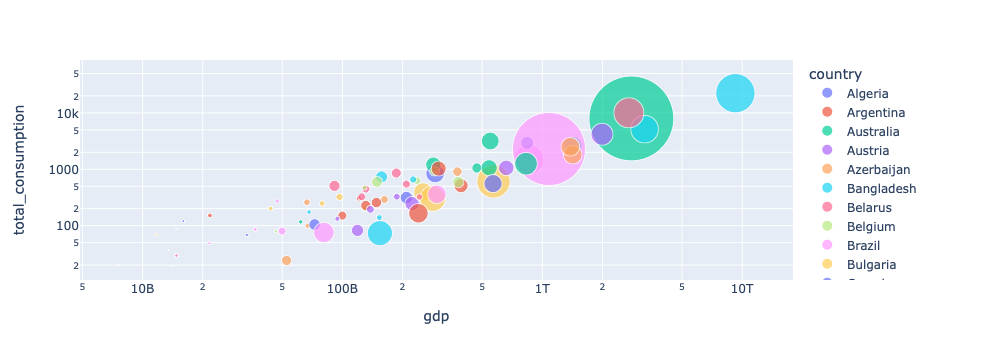

In [9]:
demo.gapminder(1990)

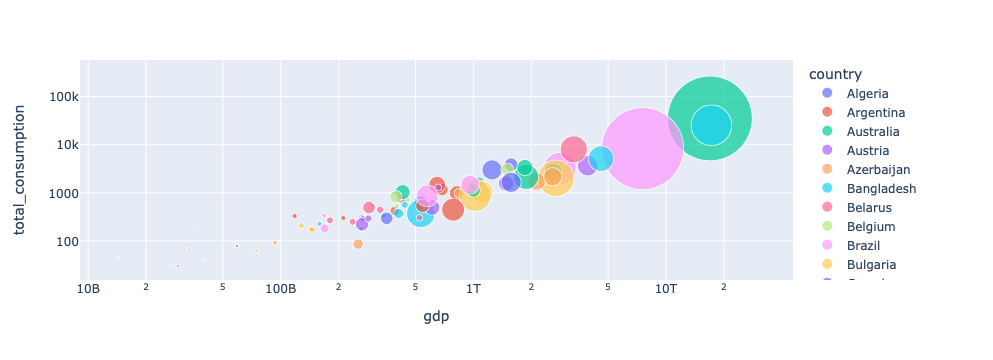

In [14]:
demo.gapminder(2016)

When analyzing the gapminder plot from 1990 to that of 2016, two intersting things meet the eye. The first is the general shift of all countries, towards a higher GDP and an increase in total consumption. The second aspect is that China has caught up to, and even surpassed the USA in terms of consumption. Also India has significantly increased its GPD and consumption, along with a rising numbers in population.

<AxesSubplot:xlabel='year'>

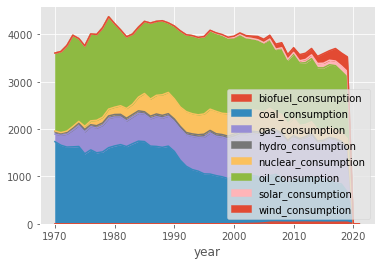

In [48]:
#Use your methods to analyse the evolution of each country's energy mix. Describe briefly what the evolution of the mix is, both totally and relatively.
demo.consumption_area_plot('Germany', False)

<AxesSubplot:xlabel='year'>

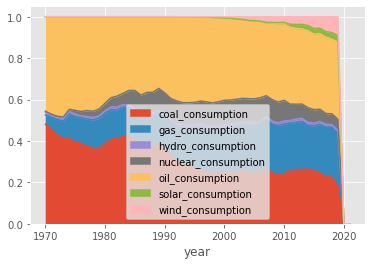

In [47]:
demo.consumption_area_plot('Germany', True)

<AxesSubplot:xlabel='year'>

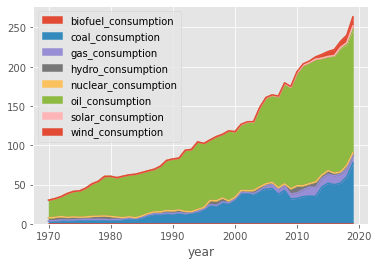

In [49]:
demo.consumption_area_plot('Morocco', False)

<AxesSubplot:xlabel='year'>

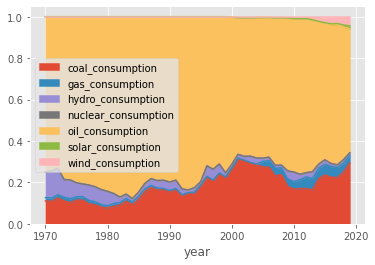

In [50]:
demo.consumption_area_plot('Morocco', True)

<AxesSubplot:xlabel='year'>

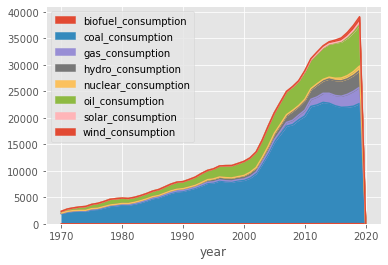

In [51]:
demo.consumption_area_plot('China', False)

<AxesSubplot:xlabel='year'>

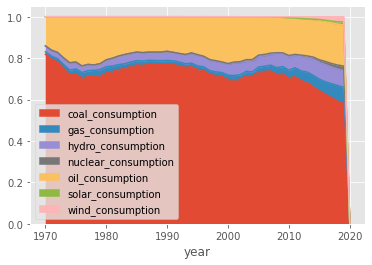

In [52]:
demo.consumption_area_plot('China', True)

Germany: Germany has experienced a drop in coal consumption compared to previous years, but coal and gas consumption still make up for the largest energy sources. Solar and wind have been increasing over the last couple years, but relatively still account for only a marginal part of resources.

Morocco: Morocco has seen a steep increase in total energy consumption since 1970. Relatively speaking fossil fuels (coal and oil) are by far the biggest consumption form. Accounting for approx 90% of the energy consumption.

China: While Chinas consumption has steadily increased since 1970, it has skyrocketed since the year 2000-2001. This goes hand in hand with Chinas plans, to catch up with the rest of the world, which were established around the same time. China is a heavy coal consumer, but there is a pleasant trend visible, where the coal consumption is relatively decreasing since 2010.

In [76]:
#Check GDP evolution for each country you selected. Make a brief analysis for each country.
demo.gdp_over_years(['Germany', 'Morocco', 'China'])

country,Germany,Morocco,China
year,,,
1970,1.290000e+12,4.791791e+10,1.060000e+12
1971,1.330000e+12,5.060293e+10,1.140000e+12
1972,1.390000e+12,5.181571e+10,1.130000e+12
1973,1.460000e+12,5.366269e+10,1.210000e+12
1974,1.470000e+12,5.656411e+10,1.240000e+12
1975,1.480000e+12,6.034804e+10,1.310000e+12
1976,1.560000e+12,6.699366e+10,1.290000e+12
1977,1.610000e+12,7.027654e+10,1.330000e+12
1978,1.650000e+12,7.231209e+10,1.510000e+12


When looking at the development of GDP for the three countries selected, it is obvious that China and Morocco have seen a significantly larger percentual increase in GDP than Germany. Whether there is a correlation between that and the carbon tax the EU has put into place or not, cannot be checked using the data at hand. 

<AxesSubplot:xlabel='country'>

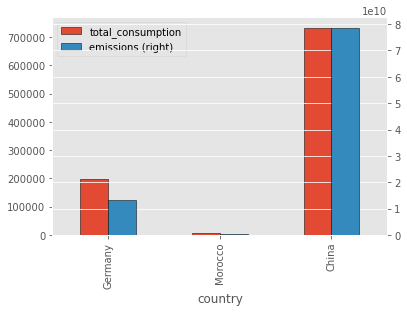

In [77]:
#Check GDP total energy consumption for each country you selected. Make a brief analysis for each country.
demo.consumption_country(['Germany', 'Morocco', 'China'])

Unlike Morocco and China, Germany consumes almost twice as much as it has emissions. That means Germany has imported a lot of energy from other countries.

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=604.860, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=606.414, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=608.410, Time=0.04 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=609.807, Time=0.05 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=610.403, Time=0.07 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=613.749, Time=0.14 sec
 ARIMA(0,1,6)(0,0,0)[1] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,7)(0,0,0)[1] intercept   : AIC=614.207, Time=0.15 sec
 ARIMA(0,1,8)(0,0,0)[1] intercept   : AIC=620.171, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=606.416, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=608.410, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=610.089, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,6)(0,0,0)[1] intercept   : AIC

/Users/moritzhackel/opt/anaconda3/envs/adpro/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/moritzhackel/opt/anaconda3/envs/adpro/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/moritzhackel/opt/anaconda3/envs/adpro/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/moritzhackel/opt/anaconda3/envs/adpro/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1883.289, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1885.781, Time=0.02 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1888.756, Time=0.05 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=2101.690, Time=0.04 sec
 ARIMA(1,1,5)(0,0,0)[1] intercept   : AIC=2224.136, Time=0.05 sec
 ARIMA(1,1,6)(0,0,0)[1] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,7)(0,0,0)[1] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,8)(0,0,0)[1] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1883.119, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1885.247, Time=0.02 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=1890.529, Time=0.11 sec
 ARIMA(2,1,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,1,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,6)(0,0,0)[1] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,7)(0,0,0)[1] intercept   : AIC=inf

/Users/moritzhackel/opt/anaconda3/envs/adpro/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/moritzhackel/opt/anaconda3/envs/adpro/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/moritzhackel/opt/anaconda3/envs/adpro/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/moritzhackel/opt/anaconda3/envs/adpro/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/var/folders/nj/l65fq51j6dv5mtgrp8lmbqd00000gn/T/ipykernel_5956/2223283117.py:411: UserWarning:

Matplotlib is currently using module://matplotlib_

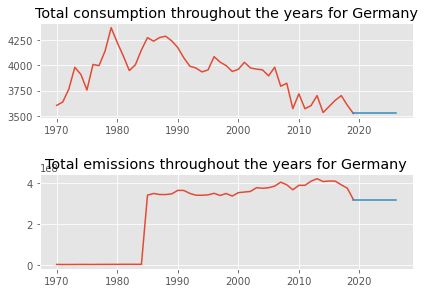

In [81]:
demo.arima_forecast('Germany', 7)

 ARIMA(0,2,0)(0,0,0)[1]             : AIC=336.879, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[1]             : AIC=306.687, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[1]             : AIC=306.073, Time=0.01 sec
 ARIMA(0,2,3)(0,0,0)[1]             : AIC=307.835, Time=0.02 sec
 ARIMA(0,2,4)(0,0,0)[1]             : AIC=309.638, Time=0.03 sec
 ARIMA(0,2,5)(0,0,0)[1]             : AIC=inf, Time=0.12 sec
 ARIMA(0,2,6)(0,0,0)[1]             : AIC=inf, Time=0.18 sec
 ARIMA(0,2,7)(0,0,0)[1]             : AIC=inf, Time=0.15 sec
 ARIMA(0,2,8)(0,0,0)[1]             : AIC=inf, Time=0.18 sec
 ARIMA(1,2,0)(0,0,0)[1]             : AIC=316.288, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[1]             : AIC=305.823, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[1]             : AIC=307.815, Time=0.02 sec
 ARIMA(1,2,3)(0,0,0)[1]             : AIC=309.797, Time=0.03 sec
 ARIMA(1,2,4)(0,0,0)[1]             : AIC=inf, Time=0.08 sec
 ARIMA(1,2,5)(0,0,0)[1]             : AIC=inf, Time=0.11 sec
 ARIMA(1,2,6)(0,0,0)[1]             : AIC=inf, Ti

/Users/moritzhackel/opt/anaconda3/envs/adpro/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/moritzhackel/opt/anaconda3/envs/adpro/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/moritzhackel/opt/anaconda3/envs/adpro/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/moritzhackel/opt/anaconda3/envs/adpro/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1559.930, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1562.313, Time=0.02 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1565.179, Time=0.02 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1568.340, Time=0.04 sec
 ARIMA(1,1,5)(0,0,0)[1] intercept   : AIC=1571.003, Time=0.04 sec
 ARIMA(1,1,6)(0,0,0)[1] intercept   : AIC=1575.176, Time=0.04 sec
 ARIMA(1,1,7)(0,0,0)[1] intercept   : AIC=1579.590, Time=0.08 sec
 ARIMA(1,1,8)(0,0,0)[1] intercept   : AIC=1607.630, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1559.750, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1561.858, Time=0.01 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1564.089, Time=0.05 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=1567.082, Time=0.03 sec
 ARIMA(2,1,4)(0,0,0)[1] intercept   : AIC=1569.428, Time=0.09 sec
 ARIMA(2,1,5)(0,0,0)[1] intercept   : AIC=1572.685, Time=0.06 sec
 ARIMA(2,1,6)(0,0,0)[1] intercept   : AIC=1576.681, Time=0.11 sec
 ARIMA(2,1

/Users/moritzhackel/opt/anaconda3/envs/adpro/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/moritzhackel/opt/anaconda3/envs/adpro/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/moritzhackel/opt/anaconda3/envs/adpro/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/moritzhackel/opt/anaconda3/envs/adpro/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/var/folders/nj/l65fq51j6dv5mtgrp8lmbqd00000gn/T/ipykernel_5956/2223283117.py:411: UserWarning:

Matplotlib is currently using module://matplotlib_

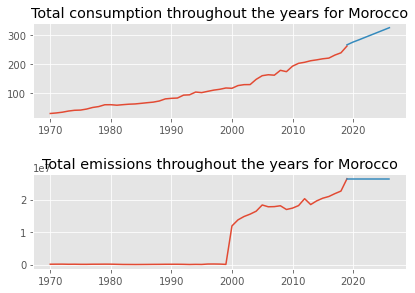

In [82]:
demo.arima_forecast('Morocco', 7)

 ARIMA(0,2,0)(0,0,0)[1]             : AIC=710.452, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[1]             : AIC=710.687, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[1]             : AIC=712.642, Time=0.02 sec
 ARIMA(0,2,3)(0,0,0)[1]             : AIC=712.163, Time=0.03 sec
 ARIMA(0,2,4)(0,0,0)[1]             : AIC=714.062, Time=0.04 sec
 ARIMA(0,2,5)(0,0,0)[1]             : AIC=707.821, Time=0.09 sec
 ARIMA(0,2,6)(0,0,0)[1]             : AIC=709.728, Time=0.12 sec
 ARIMA(0,2,7)(0,0,0)[1]             : AIC=710.594, Time=0.17 sec
 ARIMA(0,2,8)(0,0,0)[1]             : AIC=inf, Time=0.17 sec
 ARIMA(1,2,0)(0,0,0)[1]             : AIC=710.941, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[1]             : AIC=712.669, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[1]             : AIC=711.452, Time=0.06 sec
 ARIMA(1,2,3)(0,0,0)[1]             : AIC=712.906, Time=0.07 sec
 ARIMA(1,2,4)(0,0,0)[1]             : AIC=714.896, Time=0.08 sec
 ARIMA(1,2,5)(0,0,0)[1]             : AIC=709.779, Time=0.09 sec
 ARIMA(1,2,6)(0,0,0)[1]      

/Users/moritzhackel/opt/anaconda3/envs/adpro/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/moritzhackel/opt/anaconda3/envs/adpro/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/moritzhackel/opt/anaconda3/envs/adpro/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/moritzhackel/opt/anaconda3/envs/adpro/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



 ARIMA(0,2,7)(0,0,0)[1]             : AIC=1929.885, Time=0.08 sec
 ARIMA(0,2,8)(0,0,0)[1]             : AIC=1930.225, Time=0.07 sec
 ARIMA(1,2,0)(0,0,0)[1]             : AIC=1922.010, Time=0.00 sec
 ARIMA(1,2,1)(0,0,0)[1]             : AIC=1915.950, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[1]             : AIC=1918.478, Time=0.04 sec
 ARIMA(1,2,3)(0,0,0)[1]             : AIC=1922.253, Time=0.03 sec
 ARIMA(1,2,4)(0,0,0)[1]             : AIC=1922.537, Time=0.03 sec
 ARIMA(1,2,5)(0,0,0)[1]             : AIC=1925.316, Time=0.05 sec
 ARIMA(1,2,6)(0,0,0)[1]             : AIC=1928.762, Time=0.05 sec
 ARIMA(1,2,7)(0,0,0)[1]             : AIC=1931.287, Time=0.08 sec
 ARIMA(1,2,8)(0,0,0)[1]             : AIC=1932.332, Time=0.12 sec
 ARIMA(2,2,0)(0,0,0)[1]             : AIC=1919.653, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[1]             : AIC=1917.907, Time=0.02 sec
 ARIMA(2,2,2)(0,0,0)[1]             : AIC=1920.383, Time=0.04 sec
 ARIMA(2,2,3)(0,0,0)[1]             : AIC=1921.387, Time=0.04 sec
 ARIMA(2,2

/Users/moritzhackel/opt/anaconda3/envs/adpro/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/moritzhackel/opt/anaconda3/envs/adpro/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/moritzhackel/opt/anaconda3/envs/adpro/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/moritzhackel/opt/anaconda3/envs/adpro/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/var/folders/nj/l65fq51j6dv5mtgrp8lmbqd00000gn/T/ipykernel_5956/2223283117.py:411: UserWarning:

Matplotlib is currently using module://matplotlib_

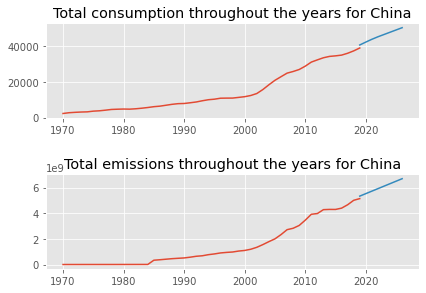

In [83]:
demo.arima_forecast('China', 7)

Lastly we want to see if we can predict how the the emissions and total consumption will develop looking 7 years into the future using an ARIMA model.
For Germany the model predicts the emissions and consumption to stay at the same level it is now.
For Morocco it predicts the consumption to increase while emissions stay the same.
For China it predicts both emissions and consumption to increase.

Looking at the Chinese agenda of becoming the biggest economical force in the world, a continued increase of emissions and consumption makes sense, as energy is necessary for most economical sectors.